In [1]:
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.9 MB/s eta 0:00:00


#DICOM loading and visualization

In [3]:
# Define directories
dataset = '/content/drive/MyDrive/medical image class/HCC_014/09-22-1998-NA-ABDPEL LIVER PROTOCOL-49588/103.000000-LIVER 3 PHASE AP-40451'
segmentation = '/content/drive/MyDrive/medical image class/HCC_014/09-22-1998-NA-ABDPEL LIVER PROTOCOL-49588/300.000000-Segmentation-69229/1-1.dcm'

def load_dicom(directory):
    slices = []
    for filename in os.listdir(directory):
        if filename.endswith('.dcm'):
            filepath = os.path.join(directory, filename)
            slices.append(pydicom.dcmread(filepath))
    slices.sort(key=lambda x: float(x.SliceLocation))
    return slices

def load_dicom_segmentation(filepath):
    return pydicom.dcmread(filepath)

# Load CT slices
ct_slices = load_dicom(dataset)
# Load segmentation data
segmentation_dcm = load_dicom_segmentation(segmentation)

print(f"Loaded {len(ct_slices)} CT slices.")

Loaded 63 CT slices.


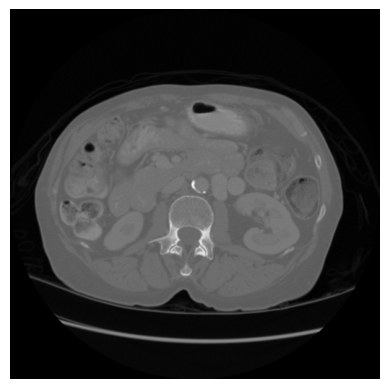

In [5]:
fifth_slice = ct_slices[4].pixel_array

plt.imshow(fifth_slice, cmap='gray')
plt.axis('off')
plt.show()

In [6]:
# Extract CT images from the slices
ct_images = np.array([s.pixel_array for s in ct_slices])

# Extract segmentation masks
segmentation_masks = segmentation_dcm.pixel_array

# Build a mapping of the segmentation masks to the corresponding CT scans
scan_to_mask_mapping = {}
per_frame_data = segmentation_dcm.PerFrameFunctionalGroupsSequence

for i, frame in enumerate(per_frame_data):
    ref_ct_uid = frame.DerivationImageSequence[0].SourceImageSequence[0].ReferencedSOPInstanceUID
    seg_number = frame.SegmentIdentificationSequence[0].ReferencedSegmentNumber
    image_position = frame.PlanePositionSequence[0].ImagePositionPatient

    if ref_ct_uid not in scan_to_mask_mapping:
        scan_to_mask_mapping[ref_ct_uid] = {}

    scan_to_mask_mapping[ref_ct_uid][seg_number] = {
        "index": i,
        "position": image_position
    }

# Reorder the segmentation masks to align with the CT slices
reordered_segmentation = []
for ct_slice in ct_slices:
    slice_mask = np.zeros_like(segmentation_masks[0])
    ct_uid = ct_slice.SOPInstanceUID

    if ct_uid in scan_to_mask_mapping:
        for seg_num, seg_info in scan_to_mask_mapping[ct_uid].items():
            mask_index = seg_info["index"]
            seg_mask = segmentation_masks[mask_index]
            slice_mask[seg_mask == 1] = int(seg_num)

    reordered_segmentation.append(slice_mask)

reordered_segmentation = np.array(reordered_segmentation)

print(f"Original segmentation masks shape: {segmentation_masks.shape}")
print(f"Reordered segmentation shape: {reordered_segmentation.shape}")

Original segmentation masks shape: (252, 512, 512)
Reordered segmentation shape: (63, 512, 512)


In [7]:

# Initialize lists to store header information
acquisition_numbers = []
slice_indices = []
image_positions = []

# Extract headers from CT slices
for i, ct_slice in enumerate(ct_slices):
    acquisition_numbers.append(ct_slice.AcquisitionNumber)
    slice_indices.append(i)
    image_positions.append(ct_slice.ImagePositionPatient)

# Initialize list for referenced segment numbers from the segmentation data
referenced_segment_numbers = []

# Extract headers from segmentation file
for frame in per_frame_data:
    referenced_segment_numbers.append(frame.SegmentIdentificationSequence[0].ReferencedSegmentNumber)

# Ensure lists are of the same length by repeating referenced_segment_numbers to match the number of CT slices
if len(acquisition_numbers) > len(referenced_segment_numbers):
    referenced_segment_numbers.extend([None] * (len(acquisition_numbers) - len(referenced_segment_numbers)))

# Create a DataFrame
header_data = {
    'Acquisition Number': acquisition_numbers,
    'Slice Index': slice_indices,
    'Image Position Patient': image_positions,
    'Referenced Segment Number': referenced_segment_numbers[:len(acquisition_numbers)]  # Ensure equal length
}

df_headers = pd.DataFrame(header_data)

df_headers.head(20)

,Acquisition Number,Slice Index,Image Position Patient,Referenced Segment Number
0,3,0,"[-179.500000, -170.000000, -210.020004]",1
1,3,1,"[-179.500000, -170.000000, -207.520004]",1
2,3,2,"[-179.500000, -170.000000, -205.020004]",1
3,3,3,"[-179.500000, -170.000000, -202.520004]",1
4,3,4,"[-179.500000, -170.000000, -200.020004]",1
5,3,5,"[-179.500000, -170.000000, -197.520004]",1
6,3,6,"[-179.500000, -170.000000, -195.020004]",1
7,3,7,"[-179.500000, -170.000000, -192.520004]",1
8,3,8,"[-179.500000, -170.000000, -190.020004]",1
9,3,9,"[-179.500000, -170.000000, -187.520004]",1


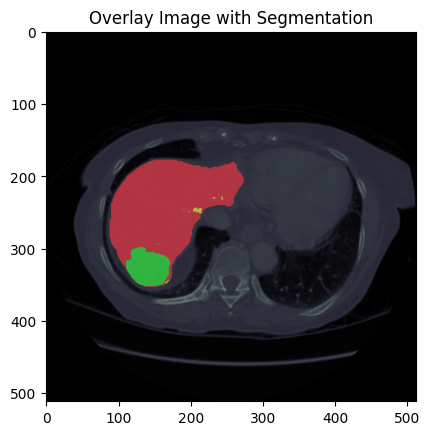

In [17]:
import os
from typing import List
import matplotlib.animation as animation
from scipy import ndimage

def alpha_fusion(img: np.ndarray, mask: np.ndarray, n_objects: int, object_colors: List, alpha: float=0.5) -> np.ndarray:
    # Normalize the image
    norm = plt.Normalize(vmin=np.amin(img), vmax=np.amax(img))
    normalized_image = norm(img)

    # Apply the colormap and select RGB channels
    cmap = plt.get_cmap('bone')
    colored_image = cmap(normalized_image)
    colored_image_rgb = colored_image[:, :, :3]

    # Create the color mask
    col_mask = np.zeros(list(mask.shape) + [3])
    for k in range(n_objects):
        col_mask[mask == (k + 1)] = object_colors[k]
    # Perform alpha blending
    blended_image = (1 - alpha) * colored_image_rgb + alpha * col_mask
    # Convert to uint8 for display
    res=(blended_image * 255).astype('uint8')

    return res

# Assign colors to each segmented region
# Liver - Red, Mass - Green, Portal vein - Yellow , Abdominal aorta - Light Blue
colors = [[1, 0, 0],[0, 1, 0],[1, 1, 0],[0.53, 0.81, 0.92]]

# Display a specific slice with the segmentation overlay
index_of_slice = 50
ct_slice = ct_images[index_of_slice]
segmentation_slice = reordered_segmentation[index_of_slice]
overlay_image = alpha_fusion(ct_slice, segmentation_slice, len(colors), colors)

plt.imshow(overlay_image)
plt.title('Overlay Image with Segmentation')
plt.show()

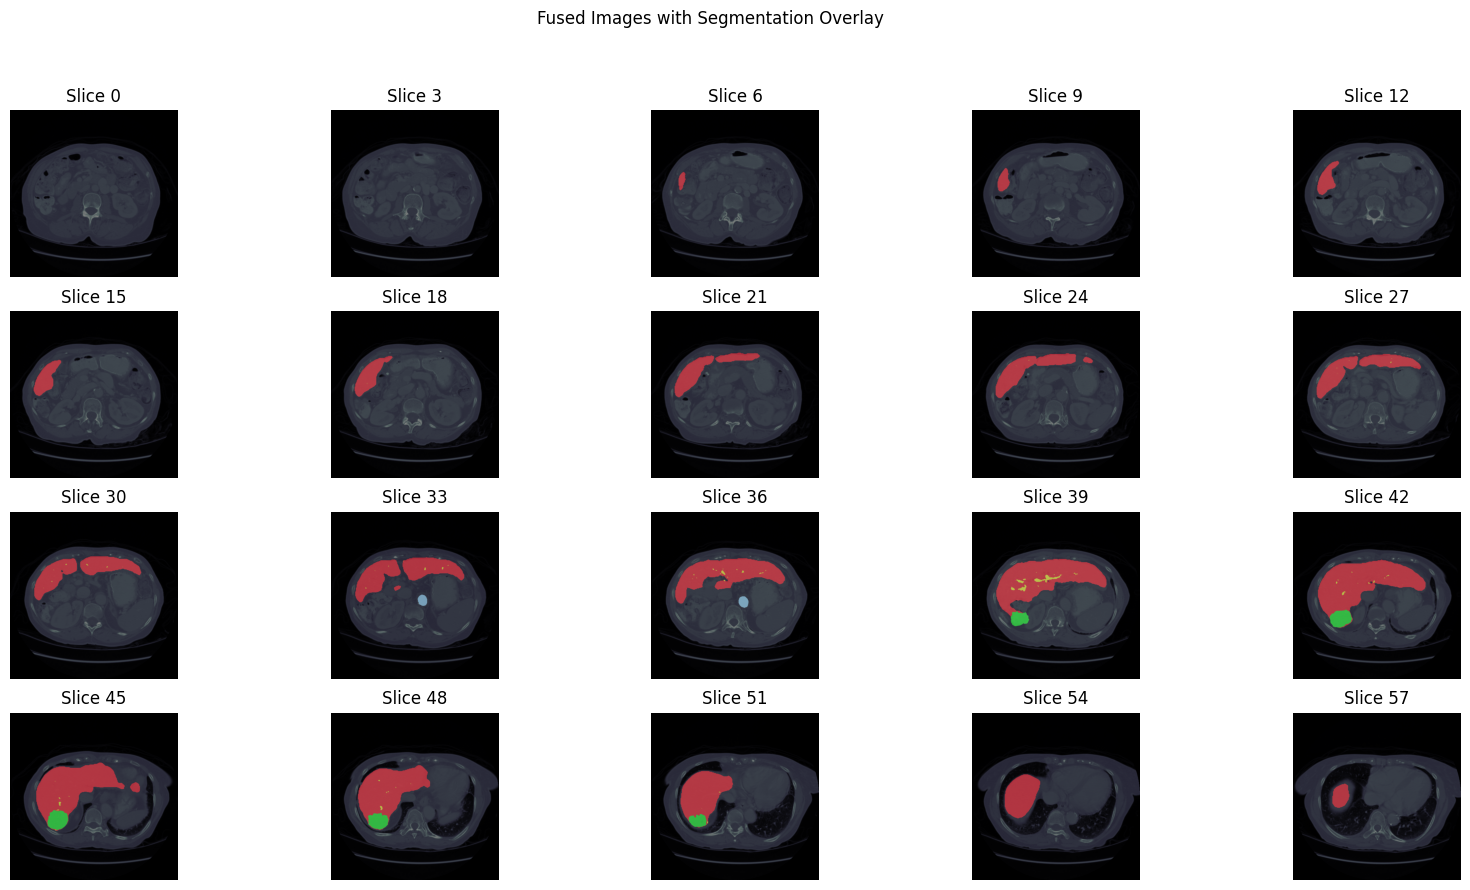

In [9]:
# Create subplots
fig, axs = plt.subplots(4, 5, figsize=(20, 10))
axs = axs.flatten()

# Visualize different slices with alpha fusion
for i, ax in enumerate(axs):
    slice_index = i * 3
    img_slice = ct_images[slice_index]
    mask_slice = reordered_segmentation[slice_index]
    fused_image = alpha_fusion(img_slice, mask_slice, len(colors), colors)
    ax.imshow(fused_image)
    ax.set_title(f'Slice {slice_index}')
    ax.axis('off')

plt.suptitle('Fused Images with Segmentation Overlay')
plt.show()

##gif

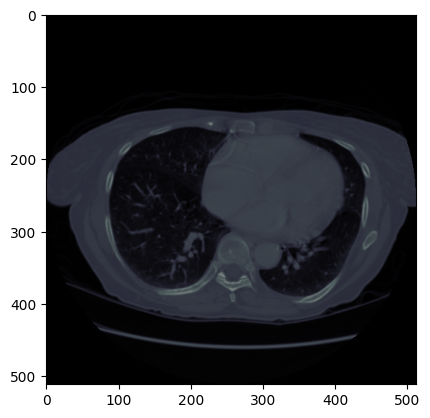

In [24]:
import os
from typing import List
import matplotlib.animation as animation
from scipy import ndimage

def apply_cmap(img: np.ndarray, cmap_name: str = 'bone') -> np.ndarray:
    cmap_function = matplotlib.colormaps[cmap_name]
    return cmap_function(img)


# Create a GIF animation
def create_gif(ct_images, segmentation_masks, object_colors, output_file):
    fig, ax = plt.subplots()
    ims = []

    for i in range(len(ct_images)):
        img_slice = ct_images[i]
        mask_slice = segmentation_masks[i]
        fused_image = alpha_fusion(img_slice, mask_slice, len(object_colors), object_colors)
        im = ax.imshow(fused_image, animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True)
    ani.save(output_file, writer='imagemagick')

    plt.show()

output_file = 'segmentation_animation.gif'
create_gif(ct_images, reordered_segmentation, colors, output_file)

##gif2

In [25]:
def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    return ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    return np.max(img_dcm, axis=2)


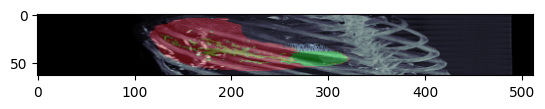

In [21]:
# Define alpha value and initialize the plot
alpha = 0.3
fig, ax = plt.subplots()

# Number of projections
n = 20
projections = []

# Generate projections for each rotation
for idx, rotation_angle in enumerate(np.linspace(0, 360 * (n - 1) / n, num=n)):
    # Rotate the CT image and segmentation blocks
    rotated_ct_img = rotate_on_axial_plane(ct_images, rotation_angle)
    rotated_seg_img = rotate_on_axial_plane(reordered_segmentation, rotation_angle)

    # Compute the maximum intensity projections (MIP) for the rotated images
    mip_ct_img = MIP_sagittal_plane(rotated_ct_img)
    mip_seg_img = MIP_sagittal_plane(rotated_seg_img)

    # Blend the projections using alpha blending
    blended_img = alpha_fusion(mip_ct_img, mip_seg_img, len(colors), colors, alpha)

    # Display and save each blended image
    plt.imshow(blended_img)
    plt.savefig(f'./Projection_{idx}.png')  # Save each projection
    projections.append(blended_img)  # Store for later animation

# Create and save the animation
animation_frames = [
    [plt.imshow(frame, animated=True)]
    for frame in projections
]
anim = animation.ArtistAnimation(fig, animation_frames, interval=150, blit=True)
anim.save('./animation.gif')
plt.show()

##with different alpha values

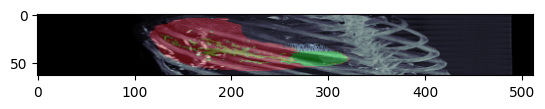

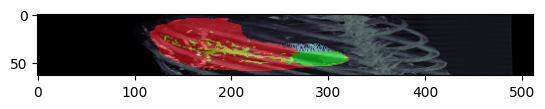

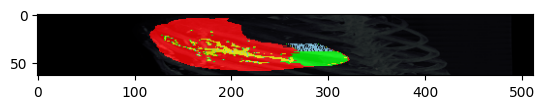

In [23]:
# The alpha values to try
alpha_values = [0.3, 0.5, 0.8]

# Number of projections
n = 20

# Iterate over each alpha value
for alpha in alpha_values:
    fig, ax = plt.subplots()
    projections = []

    # Generate projections for each rotation
    for idx, rotation_angle in enumerate(np.linspace(0, 360 * (n - 1) / n, num=n)):
        # Rotate the CT image and segmentation blocks
        rotated_ct_img = rotate_on_axial_plane(ct_images, rotation_angle)
        rotated_seg_img = rotate_on_axial_plane(reordered_segmentation, rotation_angle)

        # Compute the maximum intensity projections (MIP) for the rotated images
        mip_ct_img = MIP_sagittal_plane(rotated_ct_img)
        mip_seg_img = MIP_sagittal_plane(rotated_seg_img)

        # Blend the projections using alpha blending
        blended_img = alpha_fusion(mip_ct_img, mip_seg_img, len(colors), colors, alpha)

        # Display and save each blended image
        plt.imshow(blended_img)
        plt.savefig(f'./Projection_{alpha}_{idx}.png')  # Save each projection
        projections.append(blended_img)  # Store for later animation

    # Create and save the animation
    animation_frames = [
        [plt.imshow(frame, animated=True)]
        for frame in projections
    ]
    anim = animation.ArtistAnimation(fig, animation_frames, interval=150, blit=True)
    anim.save(f'./animation_alpha_{alpha}.gif')
    plt.show()